### Notebook for training perturbation model

In [1]:
# Notebook setup
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import scanpy as sc

import torch
import torch.nn as nn
from src.models._jedvi import JEDVI
from src.plotting import get_model_results

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 0

# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42

# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'

In [2]:
# Set working directory
work_dir = '/home/xlv0877/proj_home/dl/'
# Set output directory for training
model_dir = os.path.join(work_dir, 'models', 'eg')
model_set_p = os.path.join(work_dir, 'data', 'eg_full_model_set.h5ad')

### Load training data

2025-09-15 13:15:10,632 - INFO - Using perturbation direction to classify
2025-09-15 13:15:10,633 - INFO - Initializing dataset with 475 classes
2025-09-15 13:15:10,635 - INFO - 475 unique perturbations
2025-09-15 13:15:10,636 - INFO - 475 unique gene-perturbations
2025-09-15 13:15:10,636 - INFO - 3 unique cell types
2025-09-15 13:15:10,637 - INFO - 6 datasets
2025-09-15 13:15:10,638 - INFO - Mean number of cells / perturbation 306.1978947368421
2025-09-15 13:15:10,638 - INFO - Class embedding shape: (2426, 3072)
2025-09-15 13:15:10,638 - INFO - Adata shape: (145444, 5783)


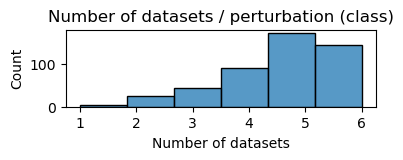

In [3]:
model_set = sc.read(model_set_p)
# define all labels to classify on
if 'perturbation_direction' in model_set.obs.columns:
    logging.info('Using perturbation direction to classify')
    cls_labels = ['perturbation_direction', 'perturbation']
else:
    cls_labels = ['celltype', 'perturbation_type', 'perturbation']
likelihood = 'zinb'
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {model_set.obs.cls_label.nunique()} classes')
logging.info(f'{model_set.obs[cls_labels[1:]].drop_duplicates().shape[0]} unique perturbations')
logging.info(f'{model_set.obs[cls_labels[-1]].nunique()} unique gene-perturbations')
logging.info(f'{model_set.obs["celltype"].nunique()} unique cell types')
logging.info(f'{model_set.obs["dataset"].nunique()} datasets')
logging.info(f'Mean number of cells / perturbation {model_set.obs.cls_label.value_counts().mean()}')
logging.info(f'Class embedding shape: {model_set.uns["cls_embedding"].shape}')
logging.info(f'Adata shape: {model_set.shape}')
fig = plt.figure(figsize=(4, 1))
ax = sns.histplot(model_set.obs.groupby('perturbation', observed=True).dataset.nunique(), bins=model_set.obs.dataset.nunique())
plt.title('Number of datasets / perturbation (class)')
plt.xlabel('Number of datasets')
plt.show()

### Train scanvi model

In [50]:
import scvi
scvi.model.SCVI.setup_anndata(model_set, batch_key=batch_key, labels_key=cls_label)
scvi_model = scvi.model.SCVI(model_set, n_latent=128, n_layers=2)
scvi_model.train(200, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 789.024. Signaling Trainer to stop.


In [51]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'unknown')
scanvi_model.train(100)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [52]:
step_model_dir = os.path.join(model_dir, 'scanvi')
os.makedirs(step_model_dir, exist_ok=True)
results, latent = get_model_results(
    model=scanvi_model, cls_labels=cls_labels, log_dir=step_model_dir, plot=True, max_classes=100
)

2025-08-30 16:16:40,593 - INFO - Processing train set
2025-08-30 16:16:40,983 - INFO - Calculating latent neighbors
2025-08-30 16:16:41,159 - INFO - Calculating latent umap
2025-08-30 16:16:55,257 - INFO - Plotting train for label: perturbation_direction
... storing 'cls_prediction' as categorical
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2025-08-30 16:16:55,870 - INFO - Plotting train for label: perturbation
2025-08-30 16:16:57,622 - INFO - Plotting train for label: None
100%|██████████| 10/10 [00:00<00:00, 134.57it/s]
2025-08-30 16:16:58,931 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08

### Train classification model

In [45]:
%autoreload 2

In [4]:
# Define covariates, set celltype as covariate
cat_covs = None
cont_covs = None

torch.set_float32_matmul_precision('medium')

# Set logging directory
step_model_dir = os.path.join(model_dir, 'elbo+ckl+con+al')

data_params = {
    'train_size': 0.9,
    'batch_size': None,
    # Set dataloader workers
    'num_workers': 1,
    #'pin_memory': True,
    # Contrastive splitter parameters, cpp * cbp = batch_size
    'max_cells_per_batch': 32,
    'max_classes_per_batch': 16,
    'shuffle_classes': True,
    'use_contrastive_loader': 'train',
}
cls_params = {
    'n_hidden': 0, 'n_layers': 1, 'dropout_rate': 0.1,
    'use_multihead': False, 'use_cosine_similarity': True, 'temperature': 1
}
# Define encoder and decoder parameters
encoder_params = {
    'n_layers': 6,
    # Set attention parameters, set minimum and maximum head dimensions to apply attention to
    'use_attention': True, 'n_head': 8, 'min_attn_dim': 8, 'max_attn_dim': 512,
    # Other parameters
    'activation_fn': nn.LeakyReLU, 'noise_std': 0.1,
    'use_transformer_block': True
}
# No attention in the decoder to get more informative latent dimension
decoder_params = {
    'n_layers': 1, 'use_attention': False, 'activation_fn': nn.LeakyReLU
}

# Set model parameters
jedvae_params = {
    'n_latent': 128,                    # Final projection dimension
    'n_hidden': 1024,
    'dropout_rate': 0.2,
    'dispersion': 'gene',
    'use_batch_norm': 'none',
    'use_layer_norm': 'both',
    'gene_likelihood': 'nb',
    'linear_classifier': True,              # <-- removes need to align latent space to embedding
    'classifier_parameters': cls_params,
    'log_variational': True,
    'l1_lambda': 0,
    'l2_lambda': 1e-3,
    'l_mask': ['attn', 'Attention', 'class_projection'],
    'cls_weight_method': None,
    # Define classification loss strategy
    'classification_loss_strategy': 'kl',
    'focal_gamma': 1.0,
    # Temperature for contrastive loss
    'contrastive_temperature': 0.2,
    # Define reductions
    'reduction': 'sum',
    'non_elbo_reduction': 'sum',
    # Give extra encoder and decoder parameters
    'extra_encoder_kwargs': encoder_params,
    'extra_decoder_kwargs': decoder_params,
    # Randomly mask features to let model learn to deal with missing features
    'use_feature_mask': False,
    'drop_prob': 1e-6
}
# Set max epochs
max_epochs = 1400
n_stall = 0
anneal_schedules = {
    'classification_ratio': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': n_stall, 'min_weight': 1, 'max_weight': 1},
    'contrastive_loss_weight': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': n_stall, 'min_weight': 1, 'max_weight': 1},
    'alignment_loss_weight': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': n_stall, 'min_weight': 0, 'max_weight': 0},
    # Should be at least 0.2 to work properly
    'class_kl_temperature': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': 0, 'min_weight': 0.1, 'max_weight': 0.1},
}
# Set training plan parameters
plan_params = {
    'lr': 1e-4,
    'lr_patience': 30,
    'weight_decay': 1e-5,
    # Use full or fixed class embedding, incl_n_unseen regulates how many unseen to include if mode = "sample"
    'cls_emb_mode': 'full',
    'incl_n_unseen': None,
    # KL and annealing options
    'n_epochs_warmup': max_epochs,
    'min_kl_weight': 0,
    'max_kl_weight': 1,
    # Scaling for class similarities
    'target_scale': 4.0,
    'anneal_schedules': anneal_schedules,
    # Use posterior mean for classification instead of sampled z (should help generalization)
    'use_posterior_mean': 'val',
    'lr_scheduler_metric': 'validation_loss',
    'log_class_distribution': False,
    'full_val_log_every_n_epoch': 10,
    'plot_umap': None
}
# Set training params
train_params = {
    'max_epochs': max_epochs,
    'early_stopping': False,
    'early_stopping_monitor': 'validation_loss',
    'early_stopping_patience': 30,
    'check_val_every_n_epoch': 1,
    'plan_kwargs': plan_params,
    'logger': pl.loggers.TensorBoardLogger(step_model_dir)
}

In [5]:
pretrained = 'base_model' in locals()
if not pretrained:
    logging.info('Setting up model w/o pretraining.')
    # Setup anndata with model
    JEDVI.setup_anndata(
        model_set, batch_key=batch_key, labels_key=cls_label
    )
    jedvae = JEDVI(model_set, **jedvae_params.copy())
else:
    logging.info('Setting up model with pretrained scvi model.')
    jedvae = JEDVI.from_base_model(
        base_model, labels_key=cls_label, **jedvae_params.copy()
    )
# Check number of parameters for model
logging.info(f'# Parameters: {sum([p.numel() for p in jedvae.module.parameters()])}')
jedvae

2025-09-15 13:15:10,988 - INFO - Setting up model w/o pretraining.
2025-09-15 13:15:11,256 - INFO - Calculating class similarities
2025-09-15 13:15:41,998 - INFO - # Parameters: 75176361


<class 'src.models._jedvi.JEDVI'> Model with the following params: 
n_classes: 475, n_unseen_classes: 1951
Training status: Not Trained

In [ ]:
# Train the model
logging.info(f'Running at: {step_model_dir}')
runner = jedvae.train(data_params=data_params.copy(), model_params=jedvae_params.copy(), train_params=train_params.copy(), return_runner=True)
runner()
# Save results to lightning directory
results, latent = get_model_results(
    model=jedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True, max_classes=150
)

2025-09-15 13:15:42,007 - INFO - Running at: /home/xlv0877/proj_home/dl/models/eg/elbo+ckl+con+al
2025-09-15 13:15:42,008 - INFO - Epochs suggested: 55, training for 1400 epochs.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `Dat

Training:   0%|          | 0/1400 [00:00<?, ?it/s]

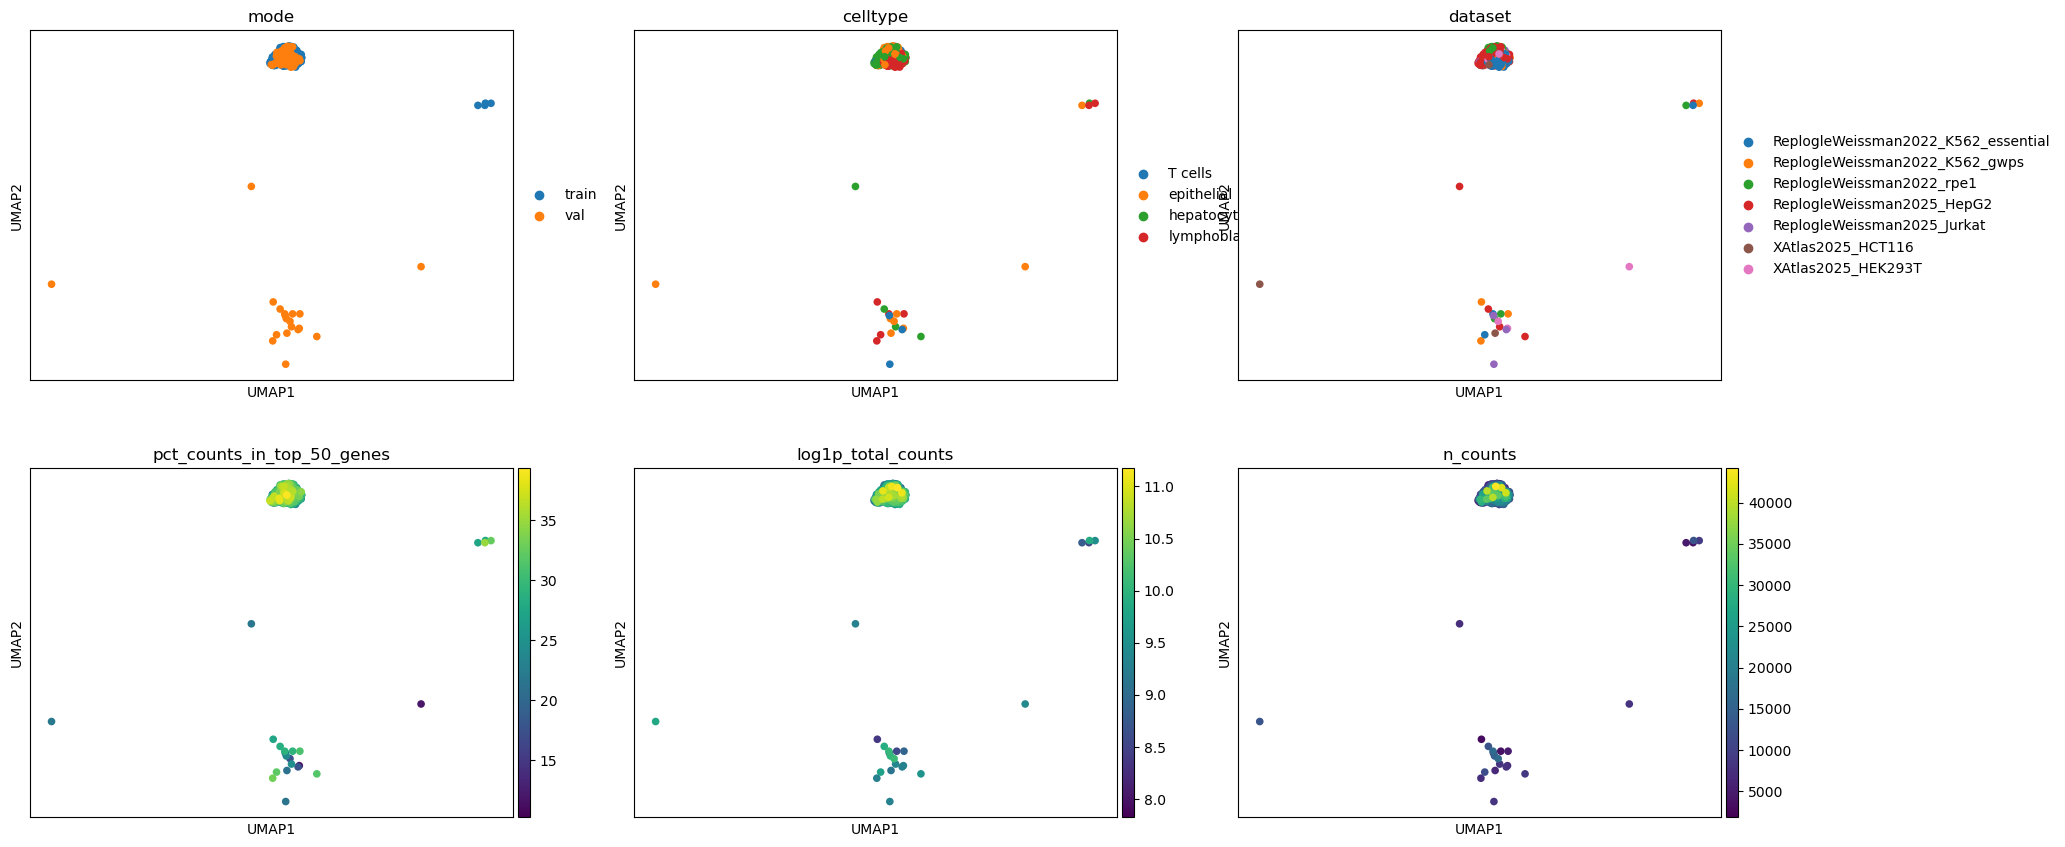

In [26]:
# Check why some cells are not validated properly
target = 'neg;CSE1L'

tmp = latent[latent.obs.cls_label==target].copy()
sc.pl.umap(tmp, color=['mode', 'celltype', 'dataset', 'pct_counts_in_top_50_genes', 'log1p_total_counts', 'n_counts'], ncols=3)

In [ ]:
# --> not cell type or dataset

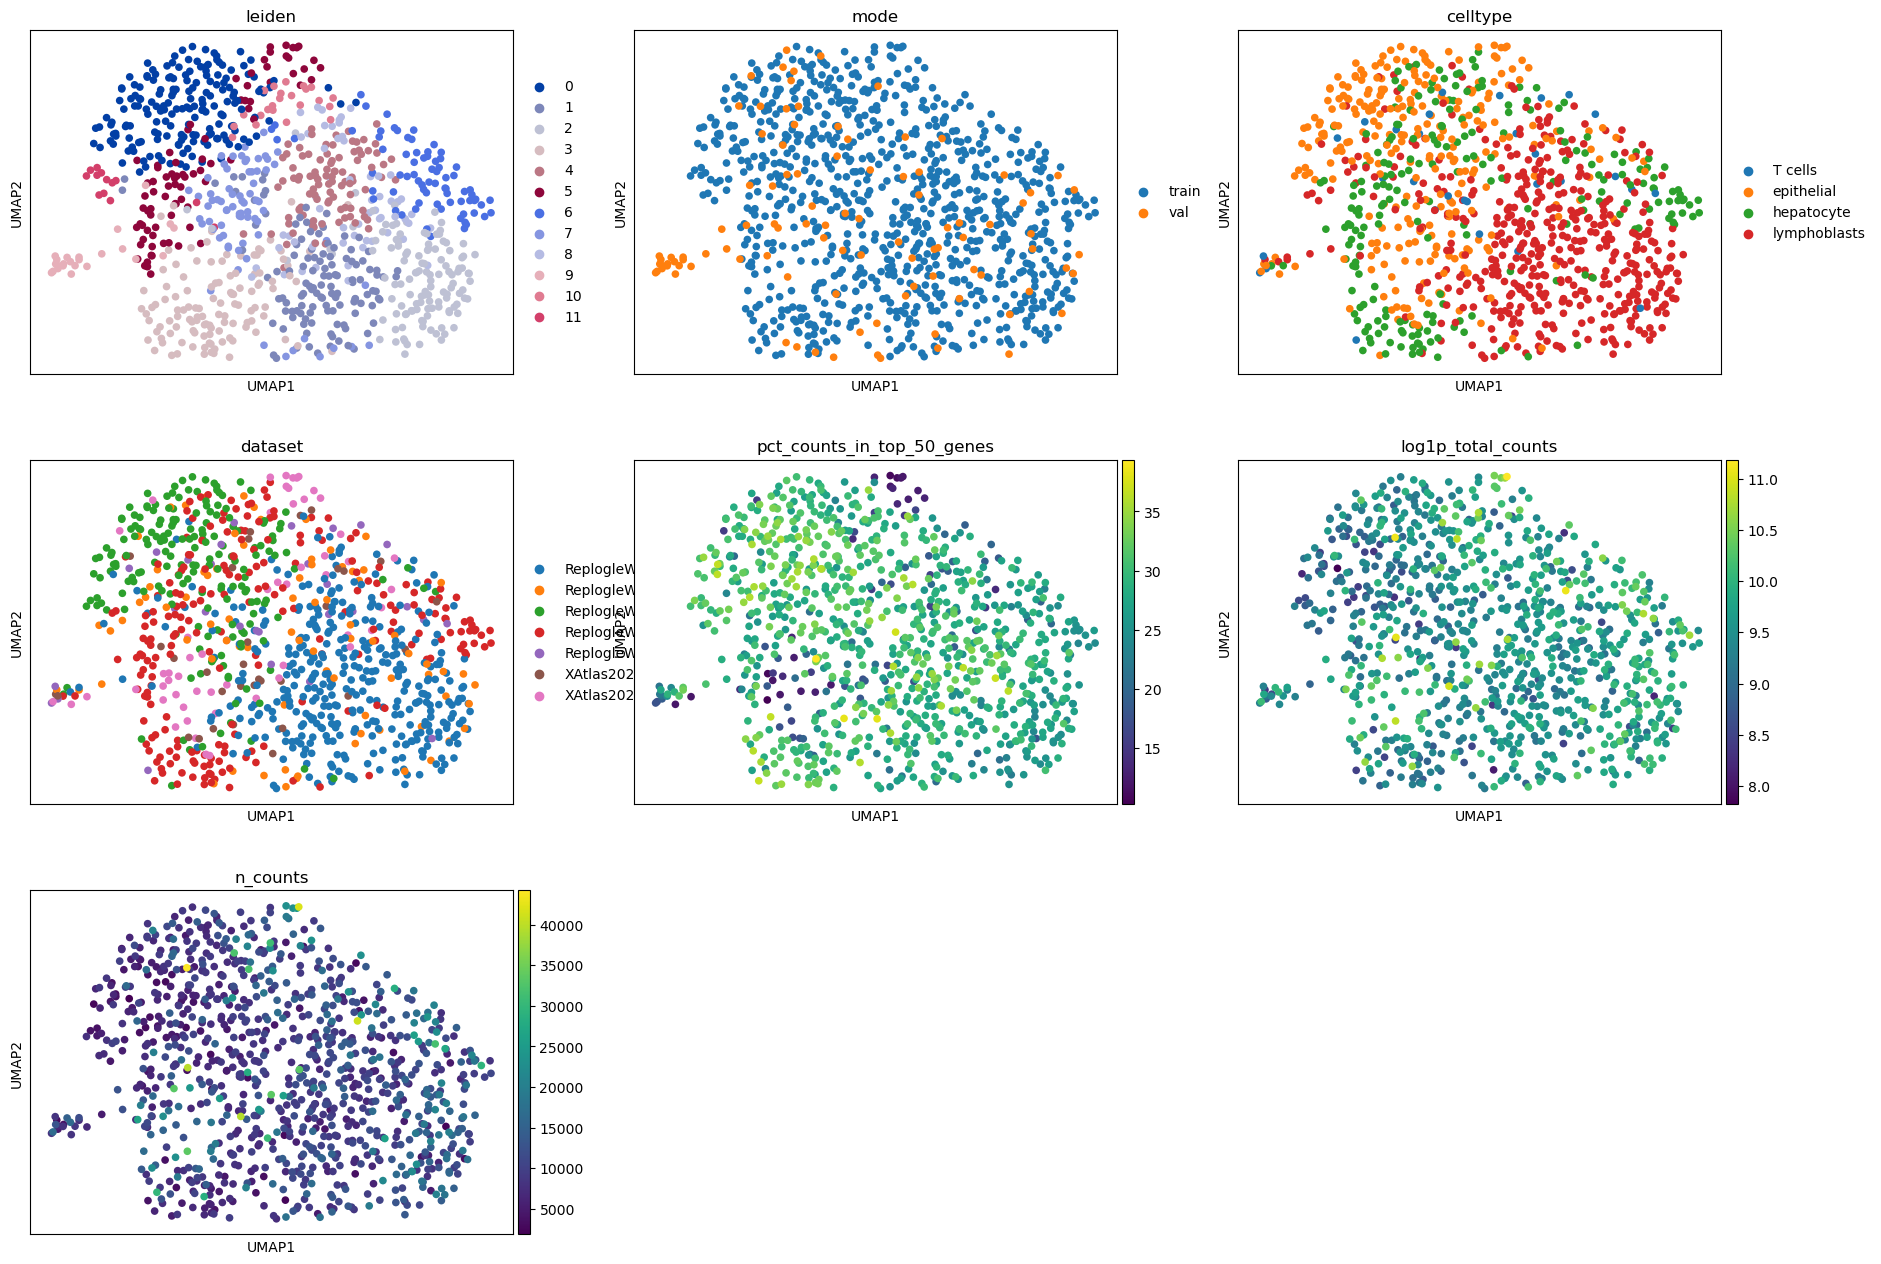

In [34]:
sc.pp.neighbors(tmp, use_rep='X')
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color=['leiden', 'mode', 'celltype', 'dataset', 'pct_counts_in_top_50_genes', 'log1p_total_counts', 'n_counts'], ncols=3)

In [47]:
# Mark outliers
# --> in this case its cluster 9
tmp.obs['outlier'] = tmp.obs.leiden.astype(int)==9
outlier_idx = tmp[tmp.obs['outlier']].obs.index

In [50]:
target_set = model_set[model_set.obs.cls_label==target].copy()
target_set.obs['outlier'] = False
target_set.obs.loc[outlier_idx,'outlier'] = True

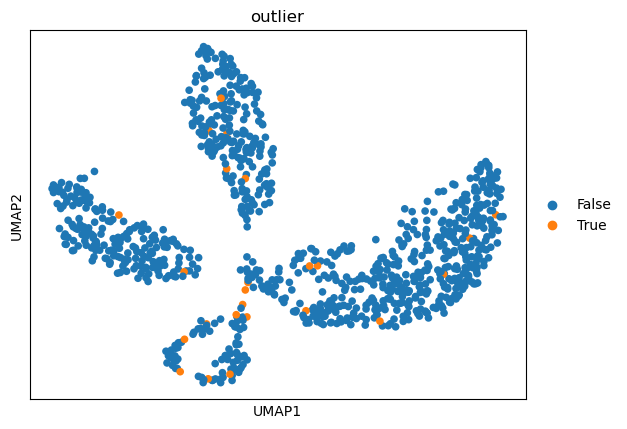

In [51]:
# Plot raw data and mark the outlier cells
sc.pp.pca(target_set)
sc.pp.neighbors(target_set)
sc.tl.umap(target_set)
sc.pl.umap(target_set, color='outlier')

In [ ]:
# --> no clear clustering or similar

In [13]:
# Check cache
cache = jedvae.module.cache
# Move all data to cpu
for cd in cache.data:
    for k,v in cd.items():
        cd[k] = v.to('cpu').detach()

In [14]:
import seaborn as sns

idx = 0
targets = np.random.choice(np.arange(512), 10)
T = 1
for target in targets:
    tmp_cache = cache.data[idx]
    # Extract data
    logits = tmp_cache['logits'][target]
    soft_targets = tmp_cache['soft_targets'][target]
    scaled_targets = tmp_cache['scaled_targets'][target]
    # Softmax now includes multiple peaks instead of just one
    plt.figure(dpi=120, figsize=(6,3))
    tmp = F.softmax(scaled_targets / T, dim=-1)
    sns.lineplot(tmp)
    #plt.ylim([0,1])
    plt.fill_between(x, tmp, alpha=0.3, color='#3e87be')
    tmp_l = F.softmax(logits / T, dim=-1) * -1
    sns.lineplot(tmp_l, color='orange')
    plt.fill_between(x, tmp_l, alpha=0.3, color='orange')
    plt.title(f'- Step: {(idx+1)*1000}')
    plt.xlabel('Class index')
    plt.ylabel('Scaled Class Probability')
    plt.show()

IndexError: list index out of range

In [ ]:
# Test the kl loss

In [11]:
%autoreload 0

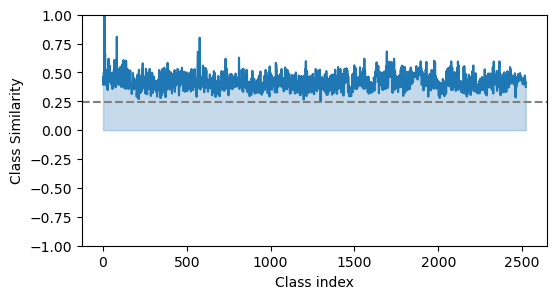

In [18]:
# Plot raw class similarities for an example cell with class c
plt.figure(dpi=100, figsize=(6,3))
x=np.arange(soft_targets.shape[0])
y=soft_targets
sns.lineplot(x=x, y=y)
plt.fill_between(x, y, alpha=0.3, color='#3e87be')
plt.ylim([-1,1])
plt.xlabel('Class index')
plt.ylabel('Class Similarity')
plt.axhline(soft_targets.min(), linestyle='--', color='grey')
plt.show()

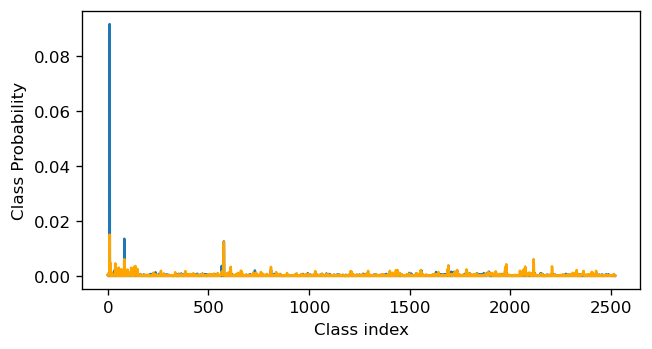

In [20]:
import torch.nn.functional as F
# Plot softmax used for kl for these raw similarities
plt.figure(dpi=120, figsize=(6,3))
tmp = F.softmax(soft_targets / 0.1, dim=-1)
tmp_l = F.softmax(logits / 0.1, dim=-1)
sns.lineplot(tmp)
plt.fill_between(x, tmp, alpha=0.3, color='#3e87be')
sns.lineplot(tmp_l, color='orange')
plt.fill_between(x, tmp_l, alpha=0.3, color='orange')
plt.xlabel('Class index')
plt.ylabel('Class Probability')
#plt.ylim([0,1])
plt.show()

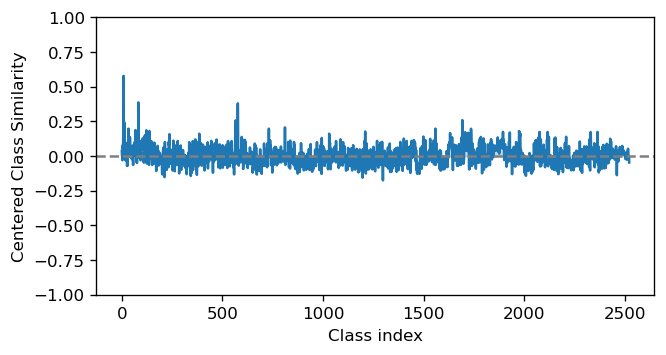

In [22]:
# Center class similarities on mean
plt.figure(dpi=120, figsize=(6,3))
tmp = (soft_targets - soft_targets.mean())
sns.lineplot(tmp)
plt.ylim([-1,1])
plt.fill_between(x, tmp, alpha=0.3, color='#3e87be')
plt.axhline(linestyle='--', color='grey')
plt.xlabel('Class index')
plt.ylabel('Centered Class Similarity')
plt.show()

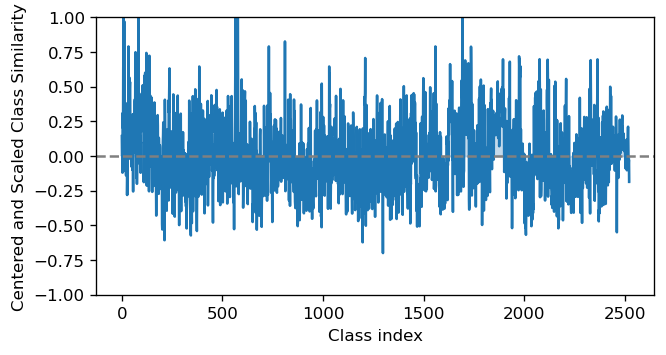

In [23]:
# Scale by fixed factor (4) and clamp at -1 and 1
plt.figure(dpi=120, figsize=(6,3))
m = soft_targets.mean()
tmp = (soft_targets - m) * 4
tmp = torch.clamp(tmp, min=-1, max=1)
sns.lineplot(tmp)
plt.fill_between(x, tmp, alpha=0.3, color='#3e87be')
plt.ylim([-1,1])
plt.axhline(linestyle='--', color='grey')
plt.xlabel('Class index')
plt.ylabel('Centered and Scaled Class Similarity')
plt.show()

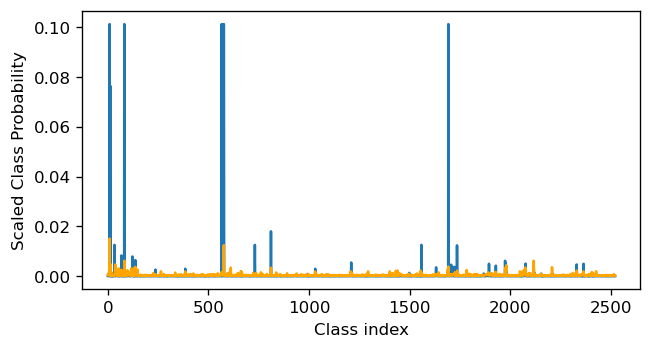

In [25]:
# Softmax now includes multiple peaks instead of just one
plt.figure(dpi=120, figsize=(6,3))
m = soft_targets.mean()
tmp = (soft_targets - m) * 4
tmp = torch.clamp(tmp, min=-1, max=1)
tmp = F.softmax(tmp / 0.1, dim=-1)
sns.lineplot(tmp)
#plt.ylim([0,1])
plt.fill_between(x, tmp, alpha=0.3, color='#3e87be')
tmp_l = F.softmax(logits / 0.1, dim=-1)
sns.lineplot(tmp_l, color='orange')
plt.fill_between(x, tmp_l, alpha=0.3, color='orange')
plt.xlabel('Class index')
plt.ylabel('Scaled Class Probability')
plt.show()